In [1]:
import pywt
import ps_lib as ps
import scipy
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt


img_path = "target-image.png"
img = ps.read_image(img_path)
print(img.shape)
LL, (LH, HL, HH) = pywt.dwt2(img, 'haar', axes = (0, 1))

img_recover = pywt.idwt2((LL, (LH, HL, HH)), 'haar', axes = (0, 1))

print(LL.shape, LH.shape, HL.shape, HH.shape)
# plt.imshow(img_recover)
# plt.show()
# plt.imshow(pywt.idwt2((LL, (None, None, None)), 'haar', axes = (0, 1)))
# plt.show()
# # Image recovered from the inverse idwt
# plt.imshow(img)
# plt.show()


(512, 512, 3)
(256, 256, 3) (256, 256, 3) (256, 256, 3) (256, 256, 3)


Quantizing Step

In [81]:
img_path = "target-image.png"
img = ps.read_image(img_path)

def convert_YcbCr(img):
    img = 255 * img
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    y  = .299 * R + .587*G + .114*B
    cb = .168736 * R -.331264 * G + .5 * B  # + 128 
    cr = .5 * R -.418688 * G - .081312*B # + 128
    return np.dstack([y, cb, cr])


In [82]:
def get_dct_coeff(img):
    dct_coeffs = np.zeros(img.shape)

    height, width = img.shape[0], img.shape[1]

    for i in range(height // 8):
        for j in range(width // 8):
            T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]

            T = np.reshape(T, (8,8))
            img_block = img[8*i:8*i+8, 8*j:8*j+8] - 128

            # M = [26, -5, -5, -5, -5, -5, -5, 8, 64, 52, 8, 26, 26, 26, 8, -18, 126, 70, 26, 26, 52, 26, -5, -5, 111, 52, 8, 52, 52, 38, -5, -5, 52, 26, 8, 39, 38, 21, 8, 8, 0, 8, -5, 8, 26, 52, 70, 26, -5, -23, -18, 21, 8, 8, 52, 38, -18, 8, -5, -5, -5, 8, 26, 8]
            # M = np.reshape(M, (8,8))
            # matrix = np.array(data).reshape(8, 8) / 255

            D = np.round(np.array(T @ img_block @ T.T), 1)
            # print(D.shape)

            # ???????
            dct_coeffs[8*i:8*i+8, 8*j:8*j+8] = D      
    return dct_coeffs

def quantize_img(dct_coeffs):
    q_mat=np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
    img_quantized = np.zeros(dct_coeffs.shape)
    
    height, width = dct_coeffs.shape[0], dct_coeffs.shape[1]

    for i in range(height // 8):
        for j in range(width // 8):
            D = dct_coeffs[8*i:8*i+8, 8*j:8*j+8]
            # print(D.shape)
            c = np.round(np.array(D / q_mat)).astype(np.int8)
            img_quantized[8*i:8*i+8, 8*j:8*j+8] = c
    return img_quantized

def unquantize_block(quantized_block):
    T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]
    q_mat=np.array([[16,11,10,16,24,40,51,61],
                    [12,12,14,19,26,58,60,55],
                    [14,13,16,24,40,57,69,56],
                    [14,17,22,29,51,87,80,62],
                    [18,22,37,56,68,109,103,77],
                    [24,35,55,64,81,104,113,92],
                    [49,64,78,87,103,121,120,101],
                    [72,92,95,98,112,100,103,99]])
                    
    T = np.reshape(T, (8,8))
    r = q_mat * quantized_block
    N = np.round(T.T @ r @ T) + 128
    # print(N)
    return N

In [83]:
def convert_block(img):
    # assert data.dtype == np.uint8
    # data = np.asarray(data, dtype=np.int8)
    # img = img - 128   
    dct_coefficients = get_dct_coeff(img)    
    return quantize_img(dct_coefficients)

def get_jpeg(img):
    # break image into 8x8 chunks
    quantized_img = np.zeros_like(img)
    
    for c in range(3):
        quantized_img[:, :, c] = convert_block(img[:, :, c])
    
    return quantized_img

def undo_jpeg(quantized):
    height, width = quantized.shape[0], quantized.shape[1]
    img = np.zeros(quantized.shape)
    for i in range(height // 8):
        for j in range(width // 8):
            for c in range(3):
                block = quantized[8*i:8*i+8, 8*j:8*j+8, c]
                img[8*i:8*i+8, 8*j:8*j+8, c] = unquantize_block(block)
    return img

In [84]:
img_path = "target-image.png"
img = ps.read_image(img_path)
converted_img = convert_YcbCr(img)
quantized = get_jpeg(converted_img)
recovered = undo_jpeg(quantized)

(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)
(8, 8)

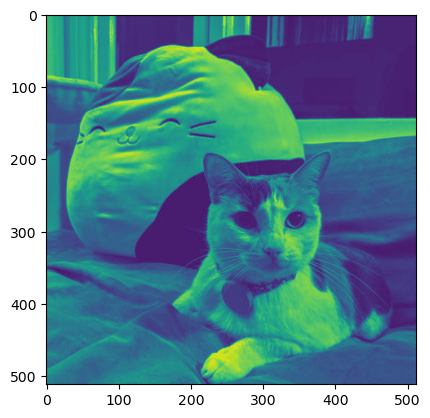

In [85]:
# print(recovered[100:108, 100:108, 0])
plt.imshow(recovered[:, :, 0])

In [43]:
lol

array([[[10, 10, 10],
        [ 4,  4,  4],
        [ 2,  2,  2],
        [ 5,  5,  5],
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 3,  3,  3],
        [ 9,  9,  9],
        [ 1,  1,  1],
        [ 2,  2,  2],
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[-7, -7, -7],
        [-5, -5, -5],
        [ 1,  1,  1],
        [-2, -2, -2],
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[-3, -3, -3],
        [-5, -5, -5],
        [ 0,  0,  0],
        [-1, -1, -1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[-2, -2, -2],
        [ 1,  1,  1],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],


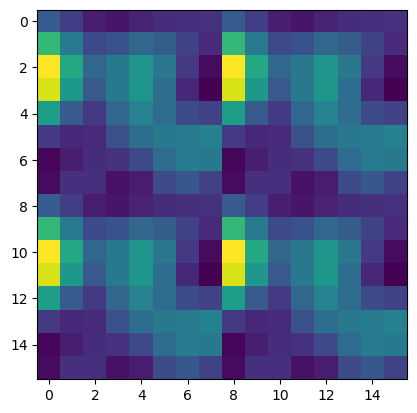

In [40]:

# print(recovered[40:50, 40:50, 0])
# print(converted_img[40:50, 40:50, 0])
plt.imshow(recovered[:16, :16, 0])


In [68]:
lolski[:, :, 0]

array([[149., 134., 119., 116., 121., 126., 127., 128.],
       [204., 168., 140., 144., 155., 150., 135., 125.],
       [253., 195., 155., 166., 183., 165., 131., 111.],
       [245., 185., 148., 166., 184., 160., 124., 107.],
       [188., 149., 132., 155., 172., 159., 141., 136.],
       [132., 123., 125., 143., 160., 166., 168., 171.],
       [109., 119., 126., 128., 139., 158., 168., 166.],
       [111., 127., 127., 114., 118., 141., 147., 135.]])

In [67]:
import numpy as np

original_data = [154, 123, 123, 123, 123, 123, 123, 136, 192, 180, 136, 154, 154, 154, 136, 110, 254, 198, 154, 154, 180, 154, 123, 123, 239, 180, 136, 180, 180, 166, 123, 123, 180, 154, 136, 167, 166, 149, 136, 136, 128, 136, 123, 136, 154, 180, 198, 154, 123, 105, 110, 149, 136, 136, 180, 166, 110, 136, 123, 123, 123, 136, 154, 136]

original_data = np.array(original_data).reshape((8, 8))

bruh = np.dstack([original_data, original_data, original_data])
print(bruh.shape)
lol =get_jpeg(bruh)
lolski = undo_jpeg(lol)

# T = [.3536, .3536, .3536, .3536, .3536, .3536, .3536, .3536, .4904, .4157, .2778, .0975, -.0975, -.2778, -.4157, -.4904, .4619, .1913, -.1913, -.4619, -.4619, -.1913, .1913, .4619, .4157, -.0975, -.4904, -.2778, .2778, .4904, .0975, -.4157, .3536, -.3536, -.3536, .3536, .3536, -.3536, -.3536, .3536, .2778, -.4904, .0975, .4157, -.4157, -.0975, .4904, -.2778, .1913, -.4619, .4619, -.1913, -.1913, .4619, -.4619, .1913, .0975, -.2778, .4157, -.4904, .4904, -.4157, .2778, -.0975]

# T = np.reshape(T, (8,8))

# M = [26, -5, -5, -5, -5, -5, -5, 8, 64, 52, 8, 26, 26, 26, 8, -18, 126, 70, 26, 26, 52, 26, -5, -5, 111, 52, 8, 52, 52, 38, -5, -5, 52, 26, 8, 39, 38, 21, 8, 8, 0, 8, -5, 8, 26, 52, 70, 26, -5, -23, -18, 21, 8, 8, 52, 38, -18, 8, -5, -5, -5, 8, 26, 8]
# M = np.reshape(M, (8,8))
# # matrix = np.array(data).reshape(8, 8) / 255

# D = np.round(np.array(T @ M @ T.T), 1) 
# print(D)


# data = np.array(original_data).reshape((8, 8)) - 128


# # Define quantization matrix for Qfactor of 50
# q_mat=np.array([[16,11,10,16,24,40,51,61],
#                 [12,12,14,19,26,58,60,55],
#                 [14,13,16,24,40,57,69,56],
#                 [14,17,22,29,51,87,80,62],
#                 [18,22,37,56,68,109,103,77],
#                 [24,35,55,64,81,104,113,92],
#                 [49,64,78,87,103,121,120,101],
#                 [72,92,95,98,112,100,103,99]])

# c = np.round(np.array(D / q_mat)).astype(np.int8)
# print(c)
# plt.imshow(lolski)


(8, 8, 3)
(8, 8)
(8, 8)
(8, 8)


# decompression


In [ ]:
r = q_mat * c
N = np.round(T.T @ r @ T) + 128
print(N)

# JPEG the image

# JPEG Dimple

In [ ]:
img_path = "images.jpg"
img = ps.read_image(img_path)
R = img[:, :, 0]
G = img[:, :, 1]
B = img[:, :, 2]
y  = .299 * R + .587*G + .114*B
plt.imshow(y[:100, :100], cmap='gray')

In [ ]:
img.shape

In [ ]:
from scipy.signal import correlate2d
from scipy.ndimage import correlate
from scipy.signal import wiener, fftconvolve


def create_template(img_shape):
    template = np.zeros(img_shape)
    template[::8, ::8] = 1
    return template

def compute_fI(img, template):
    fI = np.zeros((8, 8))
    for u in range(8):
        for v in range(8):
            shifted_template = np.roll(template, (u, v), axis=(0, 1))
            fI[u, v] = np.sum(correlate(img, shifted_template))
    return fI

def compute_fI_fft(img, template):
    fI = np.zeros((8, 8))
    for u in range(8):
        for v in range(8):
            shifted_template = np.roll(template, (u, v), axis=(0, 1))
            fI[u, v] = fftconvolve(img, shifted_template[::-1, ::-1], mode='valid').sum()
    return fI

def compute_pce(img, template):
    # ndimage is a lot faster than correlate2d????
    # fi = correlate(img, template)

    fi = compute_fI_fft(img, template)
    fi_squared = fi **2
    max_corr = np.max(fi_squared)
    # u_hat, v_hat = np.unravel_index(np.argmax(fi), fi.shape)
    
    # Calculate the correlation energy excluding the peak
    energy = np.sum(fi_squared**2) - max_corr**2
    
    # PCE calculation
    pce = max_corr**2 / (energy / (63))
    
    return pce

In [ ]:
# apply a 3 × 3 Wiener filter to each
# RGB channel and average the resulting noise residual across
# all three channels.

def compute_noise_residual(image):
    noise_residuals = []
    for i in range(3):  # Assuming the image is in RGB format
        channel = image[:, :, i]
        filtered_channel = wiener(channel, (3, 3))
        noise_residual = channel - filtered_channel
        noise_residuals.append(noise_residual)
    
    # Average the noise residuals across the three channels
    avg_noise_residual = np.mean(noise_residuals, axis=0)

    return avg_noise_residual

def average_blocks(image, block_size=32):
    height, width = image.shape
    avg_blocks = np.zeros((height // block_size + 1, width // block_size + 1))
    print(avg_blocks.shape)
    
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image[i:i + block_size, j:j + block_size]
            avg_blocks[i // block_size, j // block_size] = np.mean(block)
    
    return avg_blocks    

# To further suppress image content, nonoverlapping blocks of size 32 × 32 are then averaged across
# the entire image (or, optionally, a portion of the image). The
# PCE is then computed against this averaged 32×32 block and
# the corresponding template of the same size.

In [ ]:
img_path = "images.jpg"
img = ps.read_image(img_path)


avg_noise_residual = compute_noise_residual(img)

template = create_template(avg_noise_residual.shape)

# avg_noise_residual = avg_noise_residual - np.mean(avg_noise_residual)
# template = template - np.mean(template)
# avg_noise_residual = avg_noise_residual / np.sum(avg_noise_residual)
# template = template / np.sum(template)
pce = compute_pce(avg_noise_residual, template)
print(pce)


In [ ]:
avg_noise_residual = compute_noise_residual(img)
print(avg_noise_residual.shape)
plt.imshow(avg_noise_residual[:60, :60])
ps.write_image("noise_residual.png", avg_noise_residual[:60, :60])
plt.show()

In [ ]:
def create_per_pixel_prominence_map(image, template, window_size=32):
    height, width = image.shape
    prominence_map = np.zeros((height, width))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # define the window 
            window_row_start = max(0, i - window_size // 2)
            window_row_end = min(image.shape[0], i + window_size // 2)
            window_col_start = max(0, j - window_size // 2)
            window_col_end = min(image.shape[1], j + window_size // 2)
            
            window = image[window_row_start:window_row_end, window_col_start:window_col_end]
            
            pce_value = compute_pce(window, template)
            
            # Assign the average PCE to the prominence map
            prominence_map[i, j] = pce_value
        print(i)
    return prominence_map
template = create_template((32, 32))
prominence_map = create_per_pixel_prominence_map(y, template)

In [ ]:
print(prominence_map)

In [ ]:
np.max(prominence_map)

In [ ]:
plt.imshow(prominence_map, )

In [ ]:
plt.imshow(img)

# JPEG 2000 stuff

# Computing the DWT

In [ ]:
H = np.array([
    [1, 1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, -1, -1, -1, -1],
    [1, 1, -1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 1, -1, -1],
    [1, -1, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, -1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, -1, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, -1]
]).T


# H = np.array([])

# Normalize the matrix
norm = np.linalg.det(H)
# print(row_norms)
col_norms = np.linalg.norm(H, axis=0, keepdims=True)
# print(col_norms)
np.set_printoptions(precision=3, suppress=True)
print(H)
normalized_H = H / norm

# print(normalized_H)
row = data[0]
bruh = normalized_H @ np.array(row)
print(bruh)

# print(row)
# print(discrete_haar_wavelet_transform(row.copy()))
# print(row)
# print(row)

# approximation = np.array(two_dimensional_haar_wavelet_transform(y / 255))
# print(approximation)
# plt.imshow(approximation)
# plt.show()
# plt.imshow(y)
# plt.show()


In [ ]:
H = [[.5, .5, 0, 0, 0, 0, 0, 0], [.5, -.5, 0, 0, 0, 0, 0, 0], [0, 0, .5, .5, 0, 0, 0, 0], [0, 0, .5, -.5, 0, 0, 0, 0], [0, 0, 0, 0, .5, .5, 0, 0], [0, 0, 0, 0, .5, -.5, 0, 0], [0, 0, 0, 0, 0, 0, .5, .5], [0, 0, 0, 0, 0, 0, .5, -.5]]
H = np.reshape(H, (8, 8))
norm_factor = np.linalg.norm(H, axis=1)
H = H / norm_factor
print(H)


print(H @ row)
print(pywt.dwt(row, 'haar'))

In [ ]:
H = np.array([[.5, .5, 0, 0], [.5, -.5, 0, 0], [0, 0, .5, .5], [0, 0, .5, -.5]])
print(H @ np.array([1, 3, 3, 4]) * np.sqrt(2))

In [ ]:
print(pywt.dwt([1, 2], 'db1'))


# 2D wavelet transform

In [ ]:
def gen_harr_matrix(N: int):
    if N <= 1 or  (N & (N - 1)) != 0:
        print("N is not a multiple of 2 zodie")
        return
    
    harr = np.zeros((N, N))
    for i in range(0, N, 2):
        harr[i, i:i+2] = [1, 1]
        harr[i+1, i:i+2] = [1, -1]

    # normalizing the harr matrix so it's consistent with pwt
    return harr / np.linalg.norm(harr, axis=1)

def gen_harr_inverse(N: int):
    return np.linalg.inv(gen_harr_matrix(N))




In [ ]:
print(np.array2string(gen_harr_inverse(8), precision=3))

In [ ]:
zodie = np.random.randint(0, 100, size=(512, 512)) # np.array([[1,3, 1, 52], [1,3, 133, 2], [9,56, 32, 1], [1,30, 10, 57]])


def get_2d_wavelet_transform(data):
    H = gen_harr_matrix(len(data))

    row_stuff = H @ data

    # permute the rowwws

    cA_row, cD_row = row_stuff[::2, :], row_stuff[1::2, :]
    # print(cA, '\n\n',cD)
    col_stuff = H @ cA_row.T

    cA, cV = col_stuff[::2, :].T, col_stuff[1::2, :].T
    col_stuff2 = H @ cD_row.T


    cH, cD = col_stuff2[::2, :].T, col_stuff2[1::2, :].T


    # cA_pywt, (cH_pywt, cV_pywt, cD_pywt) = pywt.dwt2(data, 'haar', axes =(0, 1))

    # assert len(np.flatnonzero(~np.isclose(cA, cA_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cH, cH_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cV, cV_pywt))) == 0
    # assert len(np.flatnonzero(~np.isclose(cD, cD_pywt))) == 0
    # assert len(np.flatnonzero(cV - cV_pywt)) == 0
    # assert len(np.flatnonzero(cD - cD_pywt)) == 0
    # assert len(np.flatnonzero(cH - cH_pywt)) == 0

    return cA, (cH, cV, cD)

cA, (cH, cV, cD) = get_2d_wavelet_transform(zodie)

def get_inv_wavelet_transform(cA, cH, cV, cD):
    h_inv = gen_harr_inverse(len(cA) * 2)
    print(cH.shape)
    col_stuff2 = np.zeros_like(np.vstack([cH, cH]))
    col_stuff2[::2, :] = cH.T
    col_stuff2[1::2, :] = cD.T

    cD_row = (h_inv @ col_stuff2).T


    col_stuff = np.zeros((cH.shape[0]*2, cH.shape[1]))
    col_stuff[::2, :] = cA.T
    col_stuff[1::2, :] = cV.T

    cA_row = (h_inv @ col_stuff).T

    row_stuff = np.zeros_like(np.vstack([cA_row, cA_row]))
    row_stuff[::2, :] = cA_row
    row_stuff[1::2, :] = cD_row
    
    data = h_inv @ row_stuff
    return data


assert len(np.flatnonzero(~np.isclose(zodie, get_inv_wavelet_transform(cA, cH, cV, cD)))) == 0

# JPEG 2000 the image

In [ ]:
bruh = np.zeros((242, 241, 2)).T
print(bruh.shape)

In [ ]:
def quantize(R, i, c, f, blocks):
    base_step = 2 ** (R - c + i) * (1 + f/2**11)
    print(base_step)
    blur = blocks['blur']
    print(len(blur.flatten()))
    d = base_step / 32
    print(d)
    blur_quantize = np.sign(blur) * np.floor(np.abs(blur) / (d))
    # print(np.nonzero(blur_quantize))
    print(len(np.flatnonzero(blur_quantize)))
    
    return blur_quantize

def undo_quantize_blur(R, i, c, f, quantized_blur):
    base_step = 2 ** (R - c + i) * (1 + f/2**11)
    d = base_step / 32

    return quantized_blur * d


# quantize(8, 3, 8.5, 8, blocks)

In [ ]:
plt.imshow(img)

In [ ]:
def multiple_wavelet(img, iterations):
    blur = img
    blocks = {}
    for curr_iter in range(iterations):
        cAs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cHs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cVs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        cDs = np.zeros((blur.shape[0] //2, blur.shape[0] //2 , 3))
        for i in range(3):
            print(i)
            cA, (cH, cV, cD) = pywt.dwt2(blur[:, :, i], 'haar') #get_2d_wavelet_transform(blur[:, :, i])
            cAs[:, :, i] = cA
            cHs[:, :, i] = cH
            cVs[:, :, i] = cV
            cDs[:, :, i] = cD

        blocks[str(curr_iter)] = {}
        blocks[str(curr_iter)]['cHs'] = cHs
        blocks[str(curr_iter)]['cVs'] = cVs
        blocks[str(curr_iter)]['cDs'] = cDs
        blocks[str(curr_iter)]['cAs'] = cAs
        
        blur = cAs
    blocks['blur'] = blur
    blocks['iterations'] = iterations
    return blocks

img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

blocks = multiple_wavelet(img, 3)

# do the beautiful reconstruction thingy

wavelet_domain_img = np.zeros(img.shape)
# wavelet_domain_img[img.shape[0] // 2**2: 2*img.shape[0] // 2**2, img.shape[0] // 2**2: 2*img.shape[0] // 2**2, : ] = blocks['1']['cAs']

for i in range(blocks['iterations']):

    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = (blocks[str(i)]['cDs']+.01) * 10

    wavelet_domain_img[: img.shape[0] // 2**(i + 1), img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), : ] = blocks[str(i)]['cHs']* 10
    
    wavelet_domain_img[img.shape[0] // 2**(i + 1): 2*img.shape[0] // 2**(i + 1), 0: img.shape[0] // 2**(i + 1), : ] = blocks[str(i)]['cVs']* 10
wavelet_domain_img[:img.shape[0] // 2**(i + 1), :img.shape[0] // 2**(i + 1), : ] = blocks['blur']

# wavelet_domain_img = (wavelet_domain_img - np.min(wavelet_domain_img)) * (np.max(wavelet_domain_img) - np.min(wavelet_domain_img))
plt.imshow(wavelet_domain_img)
plt.show()

ps.write_image("cat_imgs.png", wavelet_domain_img)



In [ ]:
blur = blocks['blur']
quantized_blur = quantize(8, 3, 8.5, 8, blocks)
zero = np.zeros(blur.shape)


# Set the detail coefficients of the higher levels to None to keep only low-frequency components

low_res_image_actual = pywt.idwt2([blur, (zero, zero, zero)], 'haar', axes=(0, 1))

recovered = undo_quantize_blur(8, 3, 8.5, 8,quantized_blur)
plt.imshow((low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual)))

plt.show()
low_res_image_recovered = pywt.idwt2([recovered, (zero, zero, zero)], 'haar', axes=(0, 1))

plt.imshow((low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered)))
plt.show()

zodie = (low_res_image_recovered - np.min(low_res_image_recovered)) / (np.max(low_res_image_recovered) - np.min(low_res_image_recovered))
ps.write_image("letsgooo.png", zodie)

zodie2 = (low_res_image_actual - np.min(low_res_image_actual)) / (np.max(low_res_image_actual) - np.min(low_res_image_actual))
ps.write_image("letsgooo2.png", zodie2)

# plt.imshow(blur)
# plt.show()

In [ ]:
plt.imshow(img)

In [ ]:
plt.imshow(recovered)


In [ ]:
print(np.max(recovered))
print(np.min(recovered))

plt.hist(recovered.flatten())

In [ ]:
blocks['0']['cHs'].shape

In [ ]:
plt.imshow((blocks['0']['cDs']+.05) * 10)

In [ ]:
blocks['0']['cDs'].shape

In [ ]:
img_path = "target-image.png"
img = np.array(ps.read_image(img_path))

cAs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cHs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cVs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))
cDs = np.zeros((img.shape[0] //2, img.shape[0] //2 , 3))

for i in range(3):
    cA, (cH, cV, cD) = get_2d_wavelet_transform(img[:, :, i])
    cAs[:, :, i] = cA
    cHs[:, :, i] = cH
    cVs[:, :, i] = cV
    cDs[:, :, i] = cD

reconstructed_img = np.zeros(img.shape)
for i in range(3):
    reconstructed_img[:, :, i] = get_inv_wavelet_transform(cAs[:, :, i], cHs[:, :, i], cVs[:, :, i], cDs[:, :, i])

plt.imshow(reconstructed_img)
plt.show()


cA, (cH, cV, cD) =pywt.dwt2(img, 'haar', axes=(0,1))
plt.imshow(cA)
plt.show()
plt.imshow(cAs)
plt.show()


In [ ]:
cnt = 0
for i in range(512):
    for j in range(512):
        for k in range(3):
            cnt += 1

In [ ]:
zodie = np.array([[1,3], [2, 3]])
print(zodie, '\n')

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# norm_factor = np.linalg.norm(H, axis=1)
# print(norm_factor)


# multiplying zodie by transpose gives
# har wavelets in terms f 
print(H @ zodie)

print(pywt.dwt(zodie, 'db1', axis=0))


In [ ]:
# doing it ourselves

zodie = np.array([[1,3], [2, 3]])

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
# axis zero
# print(H @ zodie)
row_cA, row_cD = H @ zodie
print(row_cA, row_cD)

col_cA, col_cD = H @ row_cA.T 
print(col_cA, col_cD)


col_cA, col_cD = H @ row_cD.T 
print(col_cA, col_cD)

# LL, (cDh, cd)
print(pywt.dwt2(zodie, 'db1'))


In [ ]:
# zodie = np.array([[151, 123], [566, 122]])




row_cA, row_cD = pywt.dwt(zodie, 'db1', axis=0)
# downsample, keep even index cols
# brodie = np.row_stack([row_cA, row_cD])
print(row_cA, row_cD,'\n')

col_cA, col_cD = pywt.dwt(row_cA, 'db1', axis=1)
# brodie = np.column_stack([row_cA, col_cD])[::2, :]
print(col_cA, col_cD)

print("yooooo\n\n")
cols_cA, cols_cD = pywt.dwt(row_cD, 'db1', axis=1)
print(cols_cA, cols_cD)


print(pywt.dwt2(zodie, 'db1'))



In [ ]:
print(pywt.dwt(np.array([1,3,3,4]).T, 'db1'))

H = [.5, .5, .5, .5, .5, .5, -.5, -.5, np.sqrt(2)/2, -np.sqrt(2)/2, 0, 0, 0, 0, np.sqrt(2)/2, -np.sqrt(2)/2]
H = np.reshape(H, (4,4))
row_norms = np.linalg.norm(H, axis=1, keepdims=True)

H = H / row_norms

print(H)
print(H @ np.array([1, 2, 3, 4]))


In [ ]:
print(row_norms)